In [1]:
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
def find_dominant_color(cluster, centroids):
    labels = np.arange(0, len(np.unique(cluster.labels_)) + 1)
    (hist, _) = np.histogram(cluster.labels_, bins = labels)
    hist = hist.astype("float")
    hist /= hist.sum()

    colors = sorted([(percent, color) for (percent, color) in zip(hist, centroids)], key=lambda x: x[0], reverse=True)
    per, first_color = colors[0]
    return first_color.astype("uint8").tolist()

In [3]:
image_path = "test8.jpg"
image = cv2.imread(image_path)
mod_image = image.copy()
ocr_image = image.copy()
img_h, img_w, img_c = image.shape

In [4]:
ocr_res = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)
for i in ocr_res:
    print(i, ocr_res[i])

level [1, 2, 3, 4, 5, 5, 2, 3, 4, 5, 5, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 4, 5, 5, 2, 3, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 5, 4, 5, 5, 5, 2, 3, 4, 5, 2, 3, 4, 5]
page_num [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
block_num [0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10]
par_num [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
line_num [0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0

In [5]:
def find_roi(image, x, y, w, h):
    try:
        roi = image[y-5:y+h+5, x-5:x+w+5]
    except:
        try:
            roi = image[y-1:y+h+1, x-1:x+w+1]
        except:
            roi = image[y:y+h, x:x+w]

    return roi

In [6]:
def make_cluster(roi, cluster_number=5):
    roi_reshape = roi.reshape((roi.shape[0] * roi.shape[1], 3))
    cluster = KMeans(n_clusters=cluster_number, n_init=10).fit(roi_reshape)
    return cluster

In [7]:
cluster_number = 5
for i in range(len(ocr_res['text'])):
    x = ocr_res['left'][i]
    y = ocr_res['top'][i]
    w = ocr_res['width'][i]
    h = ocr_res['height'][i]

    conf = int(ocr_res['conf'][i])
    text = ocr_res['text'][i]
    text = text.strip()

    if conf > 70 and len(text) > 0:
        #roi = image[y-1:y+h+1, x-1:x+w+1]
        roi = find_roi(image, x, y, w, h)
        '''
        roi_reshape = roi.reshape((roi.shape[0] * roi.shape[1], 3))
        print(roi_reshape.shape)
        cluster = KMeans(n_clusters=cluster_number, n_init=10).fit(roi_reshape)
        '''
        cluster = make_cluster(roi)
        main_colors = find_dominant_color(cluster, cluster.cluster_centers_)

        cv2.rectangle(mod_image, (x-1,y-1), (x+w+1,y+h+1), main_colors, -1)

        
        cv2.rectangle(ocr_image, (x,y), (x+w,y+h), (255,0,0), 1)
        cv2.putText(ocr_image, str(conf)+" "+text, (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,180), 1)

    elif conf != -1 and len(text) > 0:
        cv2.rectangle(ocr_image, (x,y), (x+w,y+h), (0,255,0), 1)
        cv2.putText(ocr_image, str(conf)+" "+text, (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,180), 1)

c:\Users\PC\.conda\envs\olv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\PC\.conda\envs\olv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\PC\.conda\envs\olv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\PC\.conda\envs\olv\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory le

In [16]:
type(cluster)

sklearn.cluster._kmeans.KMeans

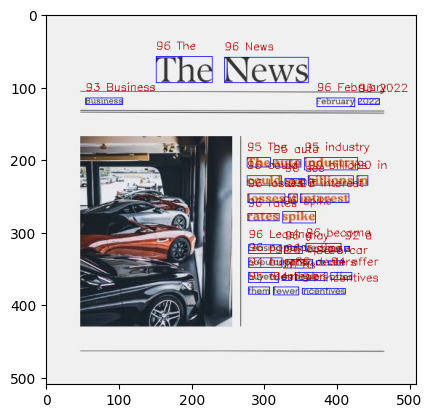

In [8]:
cv2.imwrite('ocr_result.jpg', ocr_image)
ocr_image = cv2.cvtColor(ocr_image, cv2.COLOR_BGR2RGB)
plt.imshow(ocr_image)

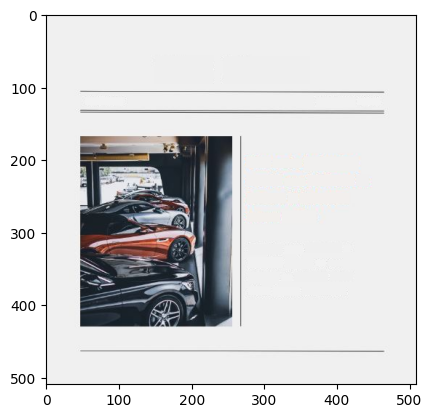

In [9]:
cv2.imwrite('remove_text_result.jpg', mod_image)
mod_image = cv2.cvtColor(mod_image, cv2.COLOR_BGR2RGB)
plt.imshow(mod_image)